# Art Rejector Try #3

In [259]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import scipy
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import xarray as xr

import hypnogram as hp
import kd_analysis.main.utils as kd
import kd_analysis.main.plots as kp
import kd_analysis.main.hypno as kh
import neurodsp.plts.utils as dspu
import sleep_score_for_me.v1.ssfm_v1 as ss
import sleep_score_for_me.utils.ssfm_utils as ssu

import adtk
from adtk.detector import GeneralizedESDTestAD
from adtk.visualization import plot

bp_def = dict(delta=(0.5, 4), theta=(4, 8), sigma = (11, 16), beta = (13, 20), low_gamma = (40, 55), high_gamma = (65, 80), omega=(300, 700))

kd_ref = {}
kd_ref['echans'] = [1,2,3,4]
kd_ref['fchans']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
kd_ref['analysis_root'] = Path('/Volumes/paxilline/Data/paxilline_project_materials/PAX_9/PAX_9_analysis_data')
kd_ref['tank_root'] = Path('/Volumes/paxilline/Data/PAX_9/PAX_9_TANK')

In [21]:
pax1_bl = '/Volumes/paxilline/Data/PAX_9/PAX_9_TANK/PAX_9-pax1-bl'
pax1 = '/Volumes/paxilline/Data/PAX_9/PAX_9_TANK/PAX_9-pax1'
good_hyp_path = '/Volumes/paxilline/Data/paxilline_project_materials/PAX_9/analysis/analysis_hypno_pax1-bl-21000.txt'

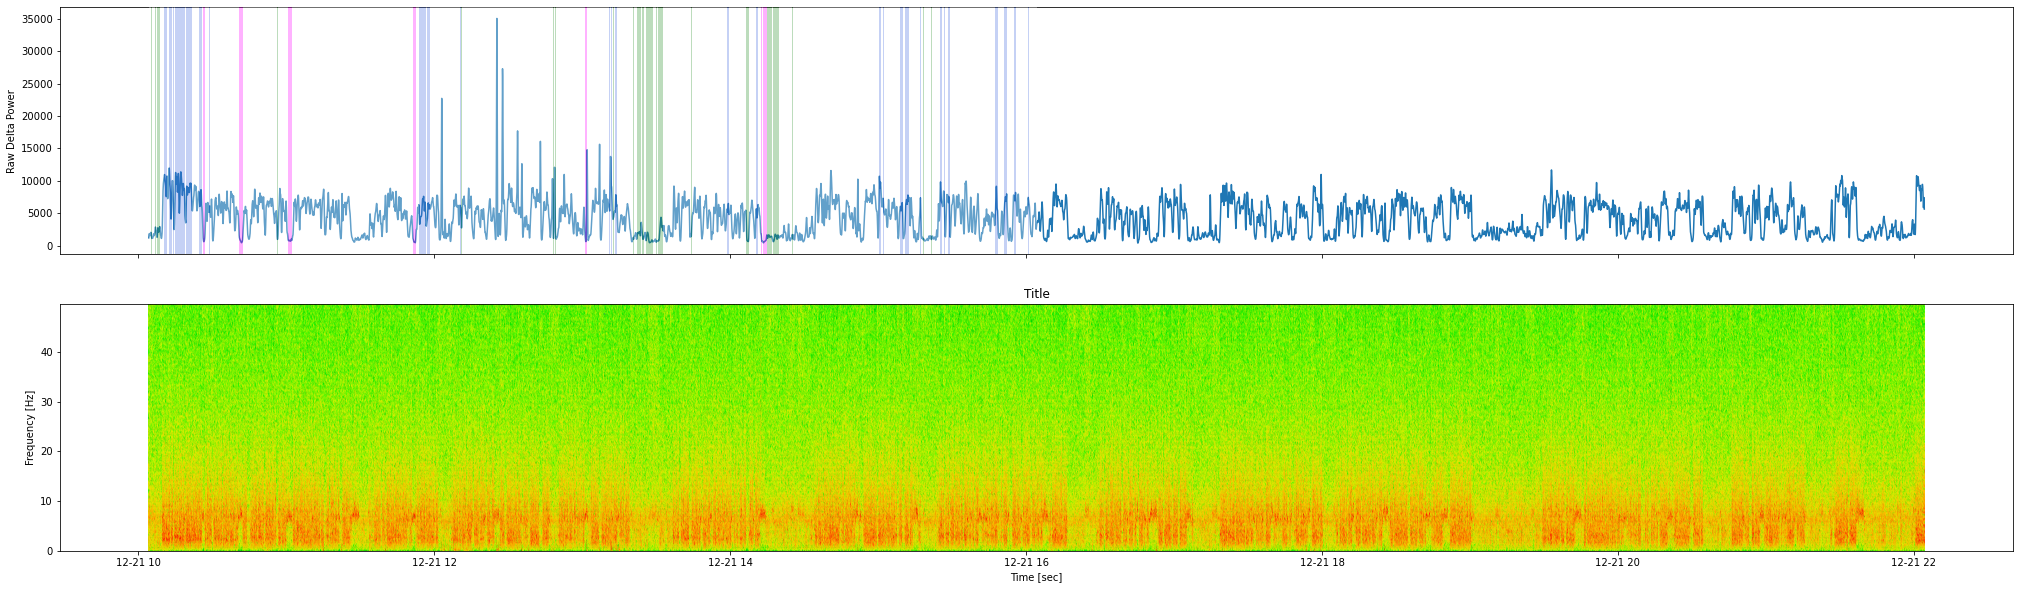

In [26]:
b, s = kp.plot_bp_and_spectro(spg, 3, good_hyp, bp_def, 'delta')

In [24]:
stw = ['Wake']
stn = ['NREM']
strem = ['REM']

In [287]:
e, spg = kd.get_data_spg(pax1_bl, store='EEGr', t1=0, t2=43200, channel=kd_ref['echans'])
m, mspg = kd.get_data_spg(pax1_bl, store='EMGr', t1=0, t2=43200, channel=[1,2])

good_hyp = kh.load_hypno_file(good_hyp_path, st=spg.datetime.values.min())

read from t=0s to t=47452.93s
Using 1017.2526 Hz as SEV sampling rate for EEGr
Passing ValueError since sig already had a time dimension
Remember to save all data in xset-style dictionary, and to add experiment name key (key = "name") before using save_xset


ValueError: cannot swap from dimension 'time' because it is not an existing dimension

In [14]:
ebp = kd.get_bp_set2(spg, bp_def)

mbp = kd.get_bp_set2(mspg, bp_def)

delta3 = ebp.delta.sel(channel=3)

omega = mbp.omega.sel(channel=1)

In [25]:
delta3_wake = kh.keep_states(delta3, good_hyp, states=stw)
omega_wake = kh.keep_states(omega, good_hyp, states=stw)

In [85]:
omega_combined = kh.keep_states(omega, good_hyp, states=['Wake', 'NREM']) 

# Build Working V1:

First get delta and omega bandpower for good-NREM:

In [66]:
good_nrem_delta = kh.keep_states(delta3, good_hyp, states=stn)
omega_nrem = kh.keep_states(omega, good_hyp, states=stn)

Then calculate the cutoffs to be used

In [123]:
delta_cut1 = 3*np.std(good_nrem_delta.values) + good_nrem_delta.values.mean()
omega_cut1 = 3*np.std(omega_nrem.values) + omega_nrem.values.mean()

Then build our scoring df to score out these first artifacts:

In [124]:
dt_ix = delta3.datetime.values

art_ser = pd.Series(delta3, index=dt_ix)
art_df = art_ser.to_frame(name='Delta')
art_df['Omega'] = omega.values
art_df['state'] = np.nan

Now score the actual artifacts using our first set of cutoffs

In [126]:
art_df.loc[np.logical_and(art_df.Delta >= delta_cut1, art_df.Omega >= omega_cut1), 'state'] = 'Art'

art_df.loc[art_df.state!='Art', 'state'] = 'Good'  

In [115]:
art_df

Delta         Omega state
2021-12-21 10:04:17.999993839   2688.643555  98640.078125  Good
2021-12-21 10:04:21.000231858   2488.355225   4994.025391  Good
2021-12-21 10:04:24.000469876   1125.671875   1959.198486  Good
2021-12-21 10:04:27.000707895   2011.697754  48733.085938  Good
2021-12-21 10:04:30.000945913   1014.427673  14836.124023  Good
...                                     ...           ...   ...
2021-12-21 22:04:00.425794903   8035.562500    178.241989  Good
2021-12-21 22:04:03.426032922   9818.558594    184.230850  Good
2021-12-21 22:04:06.426270940   9288.691406    148.012054  Good
2021-12-21 22:04:09.426508959  13657.789062    152.429657  Good
2021-12-21 22:04:12.426746977   8625.485352    172.954178  Good

[14398 rows x 3 columns]

Now we just build the hypnogram:

In [128]:
def rej_hypno_for_me(states_and_times):
    """ states_and_times --> series with only the timepoints corresponding sleep states (i.e. data that has already been 'scored')"""

    # Get boolean series for each state
    art_bool = states_and_times == 'Art'
    good_bool = states_and_times == 'Good'

    # Use the boolean series to get start and end times for each state
    art_sne = ss.starts_and_ends(art_bool)
    good_sne = ss.starts_and_ends(good_bool)

    # Then we convert the start and end times for each state to a partial hypnogram
    art_hyp = pd.DataFrame(columns = ['state', 'end_time', 'start_time', 'duration'])
    art_hyp[['start_time', 'end_time']] = art_sne
    art_hyp['duration'] = art_hyp.end_time - art_hyp.start_time
    art_hyp['state'] = 'Art'

    good_hyp = pd.DataFrame(columns = ['state', 'end_time', 'start_time', 'duration'])
    good_hyp[['start_time', 'end_time']] = good_sne
    good_hyp['duration'] = good_hyp.end_time - good_hyp.start_time
    good_hyp['state'] = 'Good'

    #Then we concat those and sort by the start_time 
    fin_hypno = pd.concat([art_hyp, good_hyp])
    fin_hypno = fin_hypno.sort_values('start_time').reset_index(drop=True)
       
    return fin_hypno

In [129]:
art_hypno_ch3 = rej_hypno_for_me(art_df['state'])

passing indexing error
passing indexing error


## Now we try Function-izing this:

In [290]:
spg_8_1 = kd.get_spextrogram(e, window_length=8, overlap=1)

ch1_art_hypno_8_1 = artifactus_rejecticus_v1(spg_8_1.sel(channel=1), mspg.sel(channel=1), bp_def, good_hyp)

ValueError: zero-size array to reduction operation maximum which has no identity

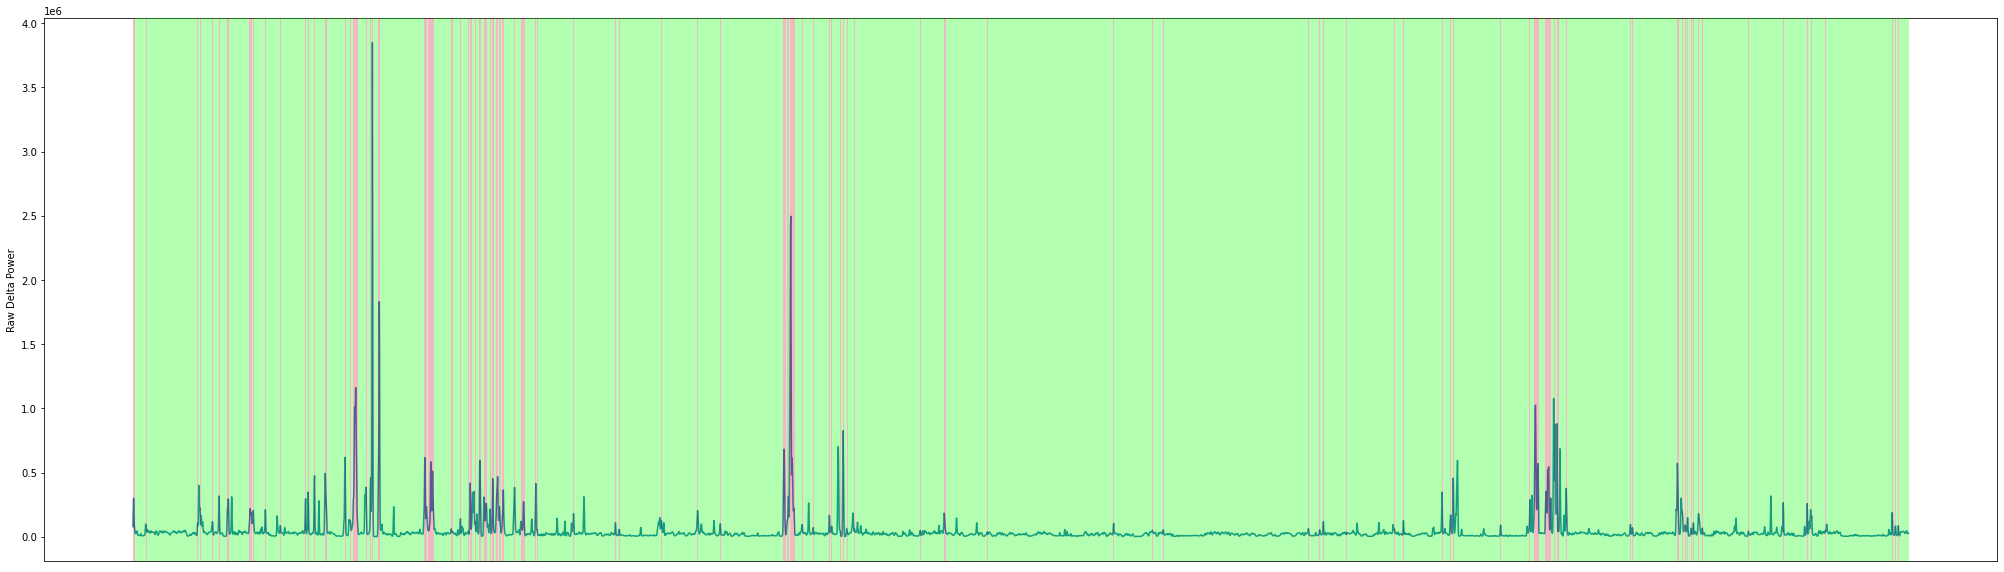

In [163]:
f, ax = plt.subplots(figsize=(35,10))
ax = kp.plot_shaded_bp(spg_8_1, 1, bp_def, 'delta', ch1_art_hypno_8_1, ax=ax)

## Figure out how to actually clean the data of the artifacts

first going to try the 'add_states' function:

In [165]:
ch1_art_hypno_8_1.keep_states(['Art'])

state                      end_time                    start_time  \
1      Art 2021-12-21 10:04:34.000444072 2021-12-21 10:04:27.000216375   
2      Art 2021-12-21 10:04:48.000899465 2021-12-21 10:04:34.000444071   
4      Art 2021-12-21 10:05:02.001354858 2021-12-21 10:04:55.001127161   
7      Art 2021-12-21 10:05:37.002493341 2021-12-21 10:05:30.002265644   
10     Art 2021-12-21 10:06:05.003404128 2021-12-21 10:05:58.003176431   
...    ...                           ...                           ...   
2651   Art 2021-12-21 21:56:22.389621244 2021-12-21 21:56:15.389393547   
2655   Art 2021-12-21 21:57:04.390987424 2021-12-21 21:56:57.390759727   
2658   Art 2021-12-21 21:57:46.392353604 2021-12-21 21:57:32.391898210   
2663   Art 2021-12-21 21:59:03.394858267 2021-12-21 21:58:56.394630570   
2668   Art 2021-12-21 22:00:13.397135233 2021-12-21 22:00:06.396907536   

                      duration  
1    0 days 00:00:07.000227697  
2    0 days 00:00:14.000455394  
4    0 days 00:00:07.000227697  
7    0 days 00:00:07.000227697  
10   0 days 00:00:07.000227697  
...                        ...  
2651 0 days 00:00:07.000227697  
2655 0 days 00:00:07.000227697  
2658 0 days 00:00:14.000455394  
2663 0 days 00:00:07.000227697  
2668 0 days 00:00:07.000227697  

[368 rows x 4 columns]

In [254]:
#Data-Based Cleaning
data_times = e.datetime.values

state_per_time = ch1_art_hypno_8_1.get_states(data_times)

times_masked = ch1_art_hypno_8_1.mask_times_by_state(data_times, states=['Art'])

data1 = e.sel(channel=1).values

cleaner = pd.Series(data1, index=data_times)

cleaner = cleaner.to_frame(name='data')

cleaner['state'] = state_per_time.values

times_masked

cleaner['mask'] = times_masked

cleaner.loc[cleaner.state=='Art', 'data'] = np.nan

new_data = cleaner['data']

new_data_x = new_data.to_xarray()

e.sel(channel=1).values = new_data_x

e.sel(channel=1).values

e.loc[dict(channel=1)] = new_data.values

spg_clean1 = kd.get_spextrogram(e, window_length=8, overlap=1)

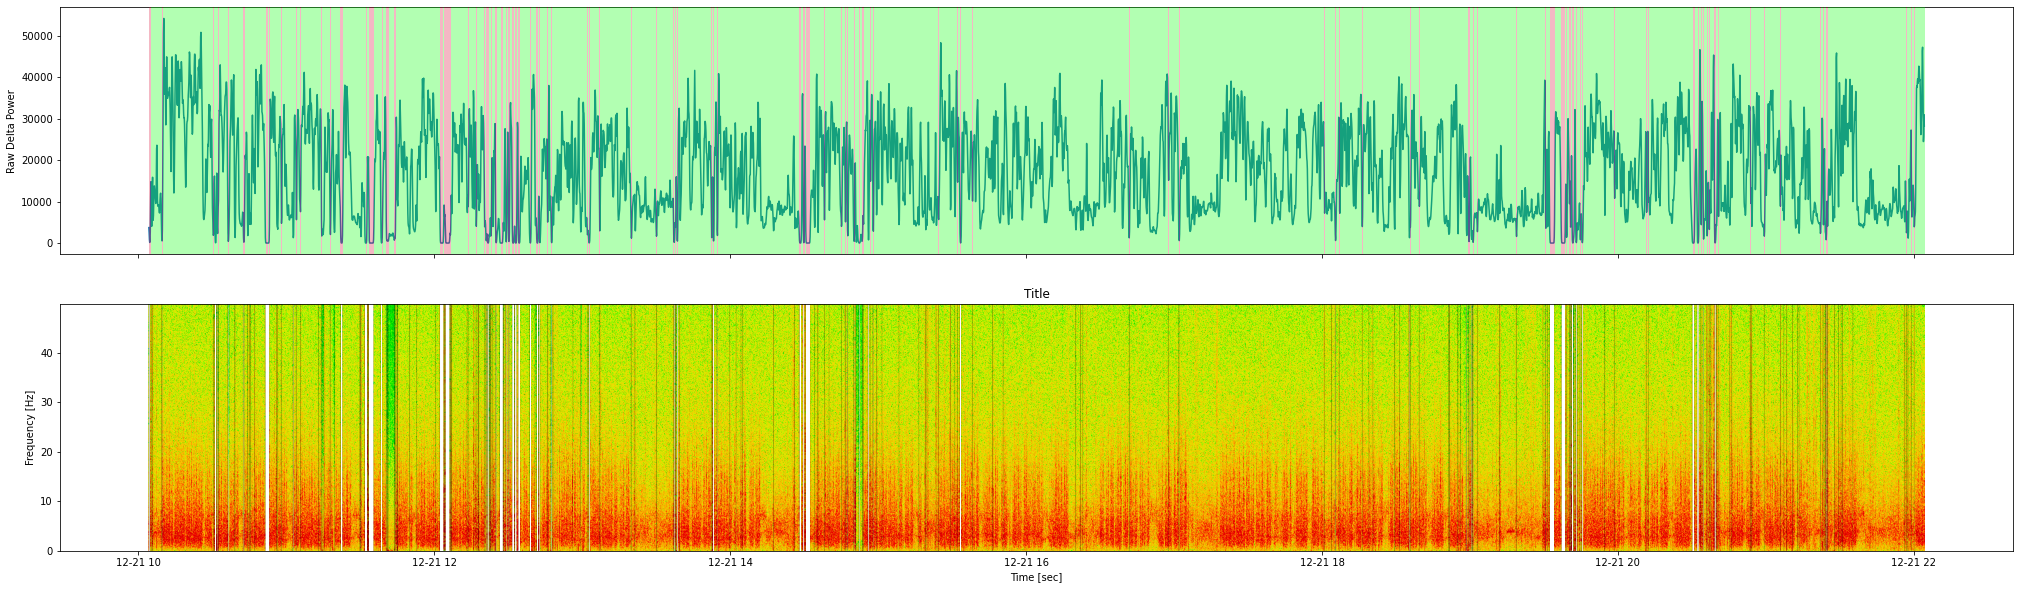

In [266]:
b, s = kp.plot_bp_and_spectro(spg_clean1, 1, ch1_art_hypno_8_1, bp_def, 'delta')

In [293]:
ac = artifactus_cleanicus(spg_8_1, ch1_art_hypno_8_1)

In [282]:
#Spectrogram Method:

spg_8_1_st = kh.add_states(spg_8_1, ch1_art_hypno_8_1)
tt = spg_8_1_st.where(spg_8_1_st.state == 'Good')

clean1 = tt.sel(channel=1).values
spg_8_1.loc[dict(channel=1)] = clean1

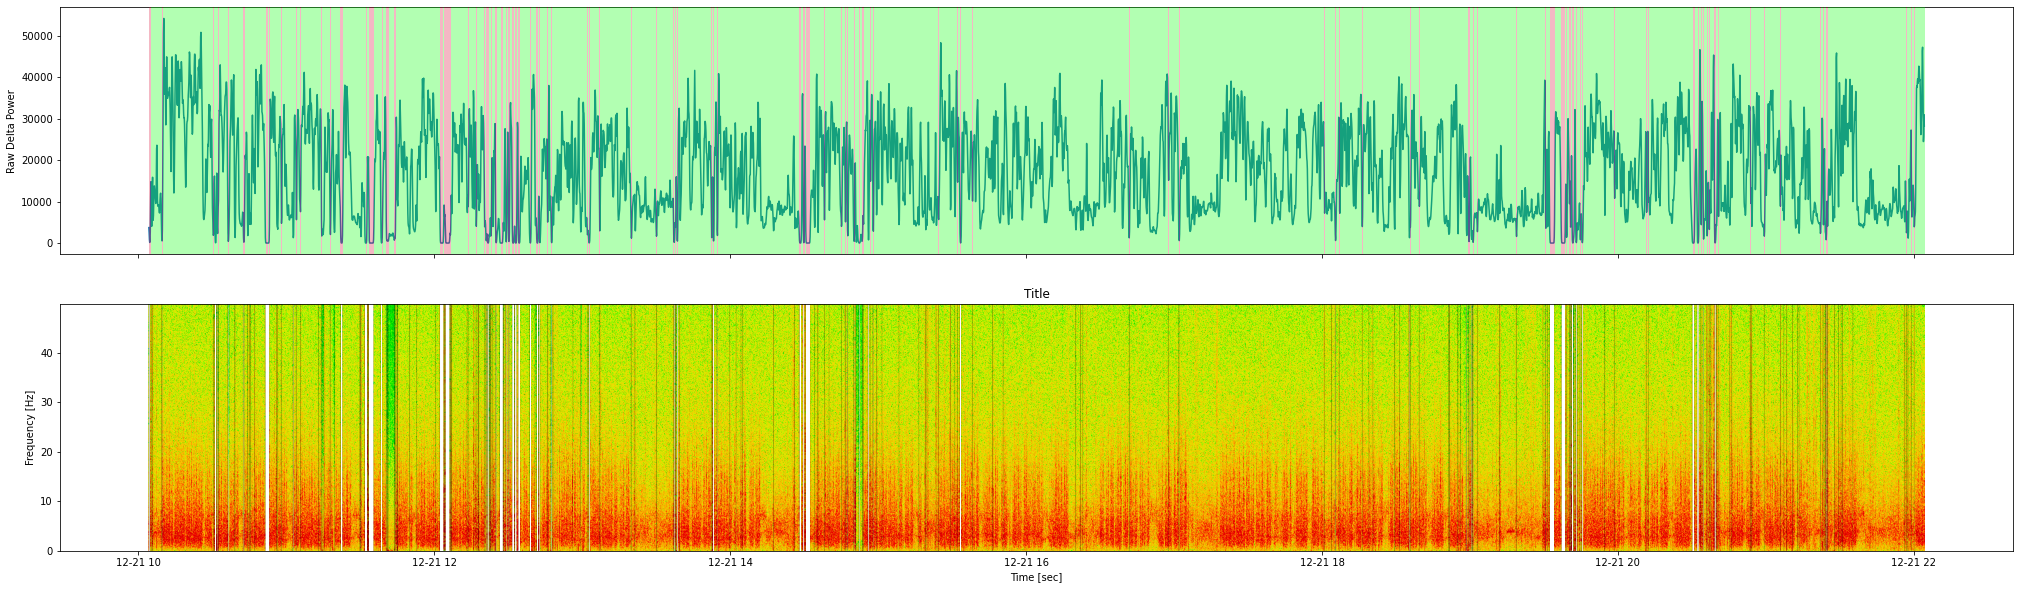

In [294]:
b, s = kp.plot_bp_and_spectro(ac, 1, ch1_art_hypno_8_1, bp_def, 'delta')

# Do it on a full spg

In [289]:
def starts_and_ends(s, minimum_duration=np.timedelta64(3, 's')):
    start_times = np.empty(0)
    end_times = np.empty(0)
    period = s.index[1] - s.index[0]

    s_trues = s[s==True]
    ix = s_trues.index
    ix_counter = np.arange(0, len(ix))

    try:
        for i in ix_counter:
            if (ix[i] - period) != ix[i-1]:
                start_times = np.append(start_times, ix[i])
            if (ix[i] + period) != ix[i+1]:
                end_times = np.append(end_times, (ix[i] + period))
            elif np.logical_and((ix[i] + period) == ix[i+1], (ix[i] - period) == ix[i-1]):
                pass 
    except IndexError:
        print('passing indexing error')
        pass
    end_times = np.append(end_times, (ix[ix_counter.max()] + period))
    return [(start_time, end_time)
            for start_time, end_time in zip(start_times, end_times)
            if end_time >= (start_time + minimum_duration)]


def build_art_hypno(states_and_times):
    """ Builds the actual formatted hypnogram once the artifact detection has already been done. 
    states_and_times --> series with only the timepoints corresponding sleep states (i.e. data that has already been 'scored')
    """

    # Get boolean series for each state
    art_bool = states_and_times == 'Art'
    good_bool = states_and_times == 'Good'

    # Use the boolean series to get start and end times for each state
    art_sne = starts_and_ends(art_bool)
    good_sne = starts_and_ends(good_bool)

    # Then we convert the start and end times for each state to a partial hypnogram
    art_hyp = pd.DataFrame(columns = ['state', 'end_time', 'start_time', 'duration'])
    art_hyp[['start_time', 'end_time']] = art_sne
    art_hyp['duration'] = art_hyp.end_time - art_hyp.start_time
    art_hyp['state'] = 'Art'

    good_hyp = pd.DataFrame(columns = ['state', 'end_time', 'start_time', 'duration'])
    good_hyp[['start_time', 'end_time']] = good_sne
    good_hyp['duration'] = good_hyp.end_time - good_hyp.start_time
    good_hyp['state'] = 'Good'

    #Then we concat those and sort by the start_time 
    fin_hypno = pd.concat([art_hyp, good_hyp])
    fin_hypno = fin_hypno.sort_values('start_time').reset_index(drop=True)
       
    return fin_hypno


def artifactus_identicus_v1(dspg, mspg, bp_def, good_hypno):
    """Detects artifacts in a recording based on neural data and EMG, returns a hypnogram which marks all timepoints as 'Good' or 'Art'
    """
    # Here we get the Bandpower sets and pull out the delta and omega from the data and muscle, respectively
    data_bp = kd.get_bp_set2(dspg, bp_def)
    mus_bp = kd.get_bp_set2(mspg, bp_def)
    delta = data_bp.delta
    omega = data_bp.omega
    
    # Here we extract the user-defined "good" NREM delta and omega, and use them to set cutoffs for artifact detection
    good_nrem_delta = kh.keep_states(delta, good_hypno, ['NREM'])
    good_nrem_omega = kh.keep_states(omega, good_hypno, ['NREM'])
    delta_cut1 = 3*np.std(good_nrem_delta.values) + good_nrem_delta.values.mean()
    omega_cut1 = 3*np.std(good_nrem_omega.values) + good_nrem_omega.values.mean()
    
    #Here we build the DF for assigning the Artifact states:
    dt_ix = delta.datetime.values
    art_ser = pd.Series(delta, index=dt_ix)
    art_df = art_ser.to_frame(name='Delta')
    art_df['Omega'] = omega.values
    art_df['state'] = np.nan
    
    # Here we actually assign the artifact and good states for all timepoints
    art_df.loc[np.logical_and(art_df.Delta >= delta_cut1, art_df.Omega >= omega_cut1), 'state'] = 'Art'
    art_df.loc[art_df.state!='Art', 'state'] = 'Good'  
    
    #Now we just build the hypnogram itself and return it
    art_hypno = build_art_hypno(art_df['state'])
    return hp.DatetimeHypnogram(art_hypno)

def artifactus_cleanicus(spg, hypno):
    """Takes in an spg with a given channel, and returns a clean version with all artifacts cleaned, based on the hypnogram for the same channel
    """
    spg_states = kh.add_states(spg, hypno)
    good_spg = spg_states.where(spg_states.state == 'Good')
    
    return good_spg

def artifactus_rejecticus(spg, mspg, bp_def, good_hypno):
    master_spg = spg
    chans = master_spg.channel.values
    
    for chan in chans:
        working_spg = spg.sel(channel=chan)
        art_hypno = artifactus_identicus_v1(working_spg, mspg, bp_def, good_hypno)
        clean_spg = arifactus_cleanicus(working_spg, art_hypno)
        
        # Here we take the clean_spg values and put them in the master_spg
        master_spg.loc[dict(channel=chan)] = clean_spg.values
        print('Channel-'+str(chan)+ ' Cleaned')
    return master_spg
    